## **Data Analysis on Ischaemic Heart Disease**

### Importing and Transforming Dataset

In [656]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import category_encoders as ce

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

from matplotlib import rcParams
rcParams['figure.figsize'] = 5,4

The dataset was taken from <a href="https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease">Personal Key Indicators</a> in Kaggle.

In [657]:
heart_disease_df = pd.read_csv('./datasets/Key Indicators of Heart Disease.csv')
heart_disease_df.head(5)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In a new dataframe, pass only the columns necessary when training a model.

In [658]:
heart_disease_df_filtered = heart_disease_df[['HeartDisease', 'Sex', 'AgeCategory', 'Race', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', 'Diabetic', 'PhysicalActivity', 'GenHealth']]
heart_disease_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   Sex               319795 non-null  object 
 2   AgeCategory       319795 non-null  object 
 3   Race              319795 non-null  object 
 4   BMI               319795 non-null  float64
 5   Smoking           319795 non-null  object 
 6   AlcoholDrinking   319795 non-null  object 
 7   Stroke            319795 non-null  object 
 8   Diabetic          319795 non-null  object 
 9   PhysicalActivity  319795 non-null  object 
 10  GenHealth         319795 non-null  object 
dtypes: float64(1), object(10)
memory usage: 26.8+ MB


Check if there are missing values

In [659]:
heart_disease_df_filtered.isna().sum()

HeartDisease        0
Sex                 0
AgeCategory         0
Race                0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
Diabetic            0
PhysicalActivity    0
GenHealth           0
dtype: int64

In [660]:
heart_disease_df_filtered.describe()

,BMI
count,319795.000000
mean,28.325399
std,6.356100
min,12.020000
25%,24.030000
50%,27.340000
75%,31.420000
max,94.850000


### Checking If Target Variable is Binary

The `HeartDisease` column is the target variable. It should only contain two unique values. In this case, it is `Yes` and `No` values.

<AxesSubplot: xlabel='HeartDisease', ylabel='count'>

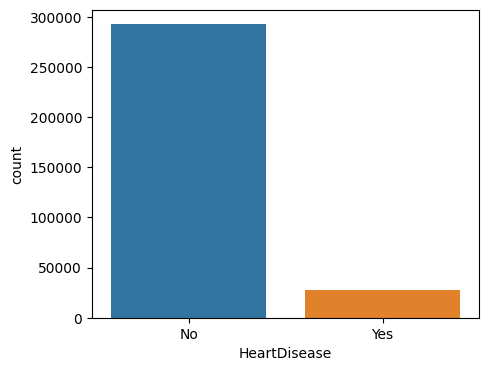

In [661]:
sb.countplot(x='HeartDisease', data=heart_disease_df_filtered)

There is an imbalance between two classes, indicating that the distribution of data is not uniform across the classes. When predicting heart disease, this can significantly skew the results of the trained model. To equalize the class distribution, we'll use SMOTE (Synthetic Minority Oversampling Method). For SMOTE to function properly, all categorical data must first be converted into binary (using dummy indications).

<em>The <b>SMOTE</b> algorithm takes in the closest minority class data entries and creates new combinations based on those entries.<sup>2</sup></em>


### Converting Categorical Features to Dummy Indicators

Get all the categorical variables

In [662]:
categorical = [var for var in heart_disease_df_filtered.columns if heart_disease_df_filtered[var].dtype=='O']

print(f'There are {len(categorical)} categorical variables:\n')
print(", ".join(categorical))

There are 10 categorical variables:

HeartDisease, Sex, AgeCategory, Race, Smoking, AlcoholDrinking, Stroke, Diabetic, PhysicalActivity, GenHealth


View frequency distribution of all categorical features. Check for any questionable values.

In [663]:
for var in categorical: 
    print(heart_disease_df_filtered[var].value_counts()/np.float(len(heart_disease_df_filtered)))
    print("--------------------------------------------------------")

No     0.914405
Yes    0.085595
Name: HeartDisease, dtype: float64
--------------------------------------------------------
Female    0.524727
Male      0.475273
Name: Sex, dtype: float64
--------------------------------------------------------
65-69          0.106790
60-64          0.105336
70-74          0.097140
55-59          0.093050
50-54          0.079370
80 or older    0.075527
45-49          0.068141
75-79          0.067174
18-24          0.065867
40-44          0.065686
35-39          0.064260
30-34          0.058641
25-29          0.053018
Name: AgeCategory, dtype: float64
--------------------------------------------------------
White                             0.766779
Hispanic                          0.085824
Black                             0.071730
Other                             0.034172
Asian                             0.025229
American Indian/Alaskan Native    0.016267
Name: Race, dtype: float64
--------------------------------------------------------
No     0.5

In [664]:
categorical_drop_first = [elem for elem in categorical if elem not in ['AgeCategory', 'Race', 'GenHealth']]
categorical_no_drop = [elem for elem in categorical if elem in ['AgeCategory', 'Race', 'GenHealth']]

Convert all categorical features to dummy indicators with 0 (No) or 1 (Yes) as the value.

In [665]:
# convert all categorical features excluding AgeCategory
heart_disease_df_dummy = pd.get_dummies(data=heart_disease_df_filtered, columns=categorical_drop_first, drop_first=True)
heart_disease_df_dummy.head(5)

,AgeCategory,Race,BMI,GenHealth,HeartDisease_Yes,Sex_Male,Smoking_Yes,AlcoholDrinking_Yes,Stroke_Yes,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy),PhysicalActivity_Yes
0,55-59,White,16.60,Very good,0,0,1,0,0,0,1,0,1
1,80 or older,White,20.34,Very good,0,0,0,0,1,0,0,0,1
2,65-69,White,26.58,Fair,0,1,1,0,0,0,1,0,1
3,75-79,White,24.21,Good,0,0,0,0,0,0,0,0,0
4,40-44,White,23.71,Very good,0,0,0,0,0,0,0,0,1


In [666]:
# convert only AgeCategory
heart_disease_df_dummy = pd.get_dummies(data=heart_disease_df_dummy, columns=categorical_no_drop)
heart_disease_df_dummy.head(5)

,BMI,HeartDisease_Yes,Sex_Male,Smoking_Yes,AlcoholDrinking_Yes,Stroke_Yes,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy),PhysicalActivity_Yes,...,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good
0,16.60,0,0,1,0,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,1
1,20.34,0,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
2,26.58,0,1,1,0,0,0,1,0,1,...,0,0,0,0,1,0,1,0,0,0
3,24.21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,23.71,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1


From the initial 11 columns, we now have 33 columns for the target features.

In [667]:
heart_disease_df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 34 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   BMI                                  319795 non-null  float64
 1   HeartDisease_Yes                     319795 non-null  uint8  
 2   Sex_Male                             319795 non-null  uint8  
 3   Smoking_Yes                          319795 non-null  uint8  
 4   AlcoholDrinking_Yes                  319795 non-null  uint8  
 5   Stroke_Yes                           319795 non-null  uint8  
 6   Diabetic_No, borderline diabetes     319795 non-null  uint8  
 7   Diabetic_Yes                         319795 non-null  uint8  
 8   Diabetic_Yes (during pregnancy)      319795 non-null  uint8  
 9   PhysicalActivity_Yes                 319795 non-null  uint8  
 10  AgeCategory_18-24                    319795 non-null  uint8  
 11  AgeCategory_2

### Creating Synthetic Data using SMOTE

In [669]:
X_features = heart_disease_df_dummy.drop(['HeartDisease_Yes'], axis=1)
y_target = heart_disease_df_dummy['HeartDisease_Yes']
y_target.value_counts()

0    292422
1     27373
Name: HeartDisease_Yes, dtype: int64

From the initial 27,373 records for 'with Heart Disease', we now have an equal number of records for both classes, i.e. 292,422.

In [670]:
oversample = SMOTE()
X_features_smoted, y_target_smoted = oversample.fit_resample(X_features, y_target)
y_target_smoted = pd.Series(y_target_smoted)
y_target_smoted.value_counts()

0    292422
1    292422
Name: HeartDisease_Yes, dtype: int64

### Creating a Model

We use Logistic Regression to create a model for predicting the Heart Disease. This model is trained by using 70% of our dataset.

In [671]:
X_train, X_test, y_train, y_test = train_test_split(X_features_smoted, y_target_smoted, test_size=0.3, random_state=0)

print(f"No. of train datasets: x={X_train.shape} y={y_train.shape}")
print(f"No. of test datasets: x={X_test.shape} y={y_test.shape}\n")

No. of train datasets: x=(409390, 33) y=(409390,)
No. of test datasets: x=(175454, 33) y=(175454,)



In [672]:
model = LogisticRegression(solver='lbfgs')
model.fit(X_train, y_train)
print(f"Model type: {model}")

Model type: LogisticRegression()


### Evaluating the Model

Classification Report

              precision    recall  f1-score   support

          No       0.81      0.76      0.78     87481
         Yes       0.77      0.82      0.80     87973

    accuracy                           0.79    175454
   macro avg       0.79      0.79      0.79    175454
weighted avg       0.79      0.79      0.79    175454



Text(0.5, 1.0, 'Confusion Matrix')

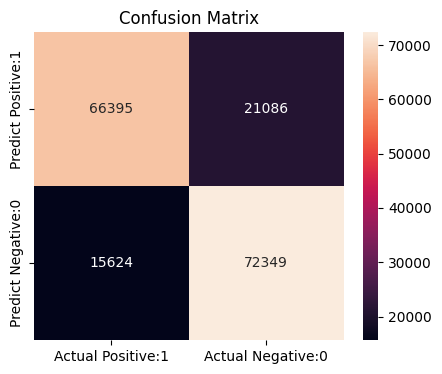

In [673]:
y_pred_test = model.predict(X_test)

print("Classification Report\n")
print(classification_report(y_test, y_pred_test, target_names=['No', 'Yes']))

cm = confusion_matrix(y_test, y_pred_test)
TN, FP, FN, TP = cm.ravel()

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], index=['Predict Positive:1', 'Predict Negative:0'])
sb.heatmap(cm_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')

The generated model for predicting the Heart Disease has an <b>accuracy score of 0.79</b>, which is the number of correct predictions out of the total number of predictions.

In [674]:
accuracy_score = (TP + TN) / float(TP + TN + FP + FN)
print(f'Accuracy score: {round(accuracy_score, 2)}')

Accuracy score: 0.79


The model has a <b>precision score of 0.77</b>, which tells us how many predictions are actually positive out of all the total positive predicted.

In [675]:
precision_score = TP / float(TP + FP)
print(f'Precision score: {round(precision_score, 2)}')

Precision score: 0.77


The model has a <b>recall score of 0.82</b>, which tells us how many predictions are actually positive out of all the positive classes.

In [676]:
recall_score = TP / float(TP + FN)
print(f'Recall score: {round(recall_score, 2)}')

Recall score: 0.82


### Make Test Prediction

In [677]:
from enum import Enum

class Field(Enum):

    BMI = 0
    Sex = 1
    Smoking = 2
    AlcoholDrinking = 3
    Stroke = 4
    DiabeticBorderline = 5
    Diabetic = 6
    DiabeticPregnancy= 7
    PhysicalActivity = 8
    AgeCategory_18_24 = 9  
    AgeCategory_25_29 = 10
    AgeCategory_30_34 = 11
    AgeCategory_35_39 = 12
    AgeCategory_40_44 = 13
    AgeCategory_45_49 = 14
    AgeCategory_50_54 = 15
    AgeCategory_55_59 = 16
    AgeCategory_60_64 = 17
    AgeCategory_65_69 = 18
    AgeCategory_70_74 = 19
    AgeCategory_75_79 = 20
    AgeCategory_80_older = 21
    Race_American_Indian = 22
    Race_Asian = 23
    Race_Black = 24
    Race_Hispanic = 25
    Race_Other = 26
    Race_White = 27
    GenHealth_Excellent = 28
    GenHealth_Fair = 29
    GenHealth_Good = 30
    GenHealth_Poor = 31
    GenHealth_Very_Good = 32


def getPrediction(input_data, model):
    df = np.array(input_data).reshape(1,-1)
    return round(model.predict_proba(df)[0][1] * 100, 2)


def testPrediction(input_data, model):

    print("PATIENT'S RECORD")
    print("--------------------------------------------")
    for key, value in input_data.items():
        print(f"{key}: {value}")
    print("--------------------------------------------")
    
    upd_input_data = [0] * (heart_disease_df_dummy.columns.size - 1)

    upd_input_data[Field.BMI.value] = input_data['BMI']
    upd_input_data[Field.Sex.value] = 1 if input_data['Sex'].lower()  == 'male' else 0
    upd_input_data[Field.AlcoholDrinking.value] = 1 if input_data['Alcohol Drinking'].lower() == 'yes' else 0
    upd_input_data[Field.PhysicalActivity.value] = 1 if input_data['Physical Activity'].lower()  == 'yes' else 0
    upd_input_data[Field.Smoking.value] = 1 if input_data['Smoking'].lower()  == 'yes' else 0
    upd_input_data[Field.Stroke.value] = 1 if input_data['Stroke'].lower()  == 'yes' else 0
    

    race = input_data['Race'].lower()
    if race in ['american indian', 'alaskan native']:
        upd_input_data[Field.Race_American_Indian.value] = 1
    elif race == 'asian':
        upd_input_data[Field.Race_Asian.value] = 1
    elif race == 'black':
        upd_input_data[Field.Race_Black.value] = 1
    elif race == 'hispanic':
        upd_input_data[Field.Race_Hispanic.value] = 1
    elif race == 'white':
        upd_input_data[Field.Race_White.value] = 1
    elif race == 'other':
        upd_input_data[Field.Race_Other.value] = 1

    
    age = input_data['Age']
    if 18 >= age <= 24:
        upd_input_data[Field.AgeCategory_18_24.value] = 1
    elif 25 >= age <= 29:
        upd_input_data[Field.AgeCategory_25_29.value] = 1
    elif 30 >= age <= 34:
        upd_input_data[Field.AgeCategory_30_34.value] = 1
    elif 35 >= age <= 39:
        upd_input_data[Field.AgeCategory_35_39.value] = 1
    elif 40 >= age <= 44:
        upd_input_data[Field.AgeCategory_40_44.value] = 1
    elif 45 >= age <= 49:
        upd_input_data[Field.AgeCategory_45_49.value] = 1
    elif 50 >= age <= 54:
        upd_input_data[Field.AgeCategory_50_54.value] = 1
    elif 55 >= age <= 59:
        upd_input_data[Field.AgeCategory_55_59.value] = 1
    elif 60 >= age <= 64:
        upd_input_data[Field.AgeCategory_60_64.value] = 1
    elif 65 >= age <= 69:
        upd_input_data[Field.AgeCategory_65_69.value] = 1
    elif 70 >= age <= 74:
        upd_input_data[Field.AgeCategory_70_74.value] = 1
    elif 75 >= age <= 79:
        upd_input_data[Field.AgeCategory_75_79.value] = 1
    elif age >= 80:
        upd_input_data[Field.AgeCategory_80_older.value] = 1


    diabetic = input_data['Diabetic'].lower()
    if diabetic  == 'yes':
        upd_input_data[Field.Diabetic.value] = 1
    elif diabetic.endswith("borderline"):
        upd_input_data[Field.DiabeticBorderline.value] = 1
    elif diabetic.endswith("during pregnancy"):
        upd_input_data[Field.DiabeticPregnancy.value] = 1
    

    general_health = input_data['General Health'].lower()
    if general_health == 'poor':
        upd_input_data[Field.GenHealth_Poor.value] = 1
    elif general_health == 'fair':
        upd_input_data[Field.GenHealth_Fair.value] = 1
    elif general_health == 'good':
        upd_input_data[Field.GenHealth_Good.value] = 1
    elif general_health == 'very good':
        upd_input_data[Field.GenHealth_Very_Good.value] = 1
    elif general_health == 'excellent':
        upd_input_data[Field.GenHealth_Excellent.value] = 1


    prediction = getPrediction(upd_input_data, model)
    print(f"\nProbability of {input_data['Name']} to get heart disease is {prediction}%")


### Test data #1

In [678]:
input_data = {
    'Name' : 'Gino Cruz',
    'Sex' : 'Male',
    'Age' : 25,
    'Race' : 'White',
    'BMI' : 16.6,
    'Smoking' : 'No',
    'Alcohol Drinking' : 'No',
    'Stroke' : 'No',
    'Diabetic' : 'No',
    'Physical Activity' : 'Yes',
    'General Health' : 'Poor'
}

testPrediction(input_data, model)

PATIENT'S RECORD
--------------------------------------------
Name: Gino Cruz
Sex: Male
Age: 25
Race: White
BMI: 16.6
Smoking: No
Alcohol Drinking: No
Stroke: No
Diabetic: No
Physical Activity: Yes
General Health: Poor
--------------------------------------------

Probability of Gino Cruz to get heart disease is 2.64%


### Test data #2

In [679]:
input_data = {
    'Name' : 'Nicole Santos',
    'Sex' : 'Female',
    'Age' : 60,
    'Race' : 'White',
    'BMI' : 46.6,
    'Smoking' : 'No',
    'Alcohol Drinking' : 'No',
    'Stroke' : 'No',
    'Diabetic' : 'Yes, during pregnancy',
    'Physical Activity' : 'Yes',
    'General Health' : 'Poor'
}

testPrediction(input_data, model)

PATIENT'S RECORD
--------------------------------------------
Name: Nicole Santos
Sex: Female
Age: 60
Race: White
BMI: 46.6
Smoking: No
Alcohol Drinking: No
Stroke: No
Diabetic: Yes, during pregnancy
Physical Activity: Yes
General Health: Poor
--------------------------------------------

Probability of Nicole Santos to get heart disease is 10.21%


### Test data #3

In [680]:
input_data = {
    'Name' : 'Alfred Gomez',
    'Sex' : 'Male',
    'Age' : 60,
    'Race' : 'White',
    'BMI' : 94.6,
    'Smoking' : 'Yes',
    'Alcohol Drinking' : 'Yes',
    'Stroke' : 'No',
    'Diabetic' : 'Yes',
    'Physical Activity' : 'No',
    'General Health' : 'Poor'
}

testPrediction(input_data, model)

PATIENT'S RECORD
--------------------------------------------
Name: Alfred Gomez
Sex: Male
Age: 60
Race: White
BMI: 94.6
Smoking: Yes
Alcohol Drinking: Yes
Stroke: No
Diabetic: Yes
Physical Activity: No
General Health: Poor
--------------------------------------------

Probability of Alfred Gomez to get heart disease is 79.23%


In [681]:
input_data = {
    'Name' : 'Erika de Leon',
    'Sex' : 'Female',
    'Age' : 80,
    'Race' : 'Asian',
    'BMI' : 94.6,
    'Smoking' : 'Yes',
    'Alcohol Drinking' : 'Yes',
    'Stroke' : 'Yes',
    'Diabetic' : 'Yes',
    'Physical Activity' : 'No',
    'General Health' : 'Poor'
}

testPrediction(input_data, model)

PATIENT'S RECORD
--------------------------------------------
Name: Erika de Leon
Sex: Female
Age: 80
Race: Asian
BMI: 94.6
Smoking: Yes
Alcohol Drinking: Yes
Stroke: Yes
Diabetic: Yes
Physical Activity: No
General Health: Poor
--------------------------------------------

Probability of Erika de Leon to get heart disease is 49.68%


### References

1. https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease
2. https://medium.com/geekculture/how-to-deal-with-class-imbalances-in-python-960908fe0425
3. https://medium.com/analytics-vidhya/what-is-a-confusion-matrix-d1c0f8feda5#:~:text=2.-,Classification%20Measure,our%20model%20and%20its%20performance.
4. https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62

> AML-2203 Winter 2023 Mid-Term Project (Group 7)